implementation of the vanila model in the following paper 

Bellec, Guillaume, Darjan Salaj, Anand Subramoney, Robert Legenstein, and Wolfgang Maass. 2018. “Long Short-Term Memory and Learning-to-Learn in Networks of Spiking Neurons.” arXiv [cs.NE]. arXiv. http://arxiv.org/abs/1803.09574.


In [5]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 

import collections
import hashlib
import numbers

from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import partitioned_variables
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import tensor_array_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util import nest
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _Linear

In [36]:
_INPUT_WEIGHT_NAME = "W_in"
_RECURRENT_WEIGHT_NAME = "W_rec"
## crossing function
def _calcualte_crossings(x,threshold):
    """input :x : a 2D tensor with batch x n 
    outputs a tensor with the same size as x 
    and values of 0 or 1 depending on comparison between 
    x and threshold""" 
    @tf.custom_gradient
    def crossings(x):
        dtype=x.dtype
        shape=x.get_shape()
        thresholds=tf.constant(threshold,shape=[shape[0].value,shape[1].value],dtype=dtype)
        # if it has one row 
        res=tf.greater_equal(x,thresholds)
        def grad(dy):
            # calculate 1-|x|
            temp=1-tf.abs(x)
            dyres=tf.maximum(temp,0.0)
            return dyres
        return tf.cast(res,dtype=dtype), grad
    z=crossings(x)
    return z 

## calculate input current to the neuron
def _linear_rec_in_current(x,y,output_size):
    """input - x : a 2D tensor with batch x n 
    y is a 2D with size batch x m
    outputs a tensor  with size batch x output_size,
    """ 
    shape_x=x.get_shape()
    shape_y=y.get_shape()
    # 
    scope=vs.get_variable_scope()
    with vs.variable_scope(scope) as outer_scope:
        weight_rec=tf.get_variable(_RECURRENT_WEIGHT_NAME,[shape_x[1],output_size]) # [n x n]
        weight_in=tf.get_variable(_INPUT_WEIGHT_NAME,[shape_y[1],output_size]) # [m x n]
        #w_in_test= lambda:tf.constant(0.0,shape=[shape_y[1],shape_y[2]]) # [n x n]
        #w_rec_test= lambda:tf.constant(0.0,shape=[shape_x[1],shape_x[2]]) # [n x n]
        #weight_rec=tf.Variable(initial_value=w_rec_test,dtype=tf.float32) # [n x n]
        #weight_in=tf.Variable(initial_value=w_in_test,dtype=tf.float32) # [n x n]
        # apply_weights 
        #recurrent
        res_rec_final=tf.matmul(x,weight_rec)
        #input
        res_in_final=tf.matmul(y,weight_in)
        # sum both 
        res=tf.add(res_in_final,res_rec_final)
        return res

## define tuples for the cell 
_LSNNStateTuple = collections.namedtuple("LSNNStateTuple", ("v_mem","spike","t_reset", "I_syn"))
_LSNNOutputTuple = collections.namedtuple("LSNNOutputTuple", ("v_mem","spike","t_reset", "I_syn"))

class LSNNStateTuple(_LSNNStateTuple):
  """Tuple used by LSNN Cells for `state_variables `, and output state.
  Stores five elements: `(v_mem,spike, t_reset, I_syn)`, in that order. Where `v_mem` is the hidden state
  , spike is output, `S_rec` and 'S_in' are spike history, and t_reset refractory history.
  Only used when `state_is_tuple=True`.
  """
  __slots__ = ()

  @property
  def dtype(self):
    (v_mem, spike,t_reset, I_syn) = self
    if v_mem.dtype != spike.dtype:
      raise TypeError("Inconsistent internal state: %s vs %s" %
                      (str(v_mem.dtype), str(spike.dtype)))
    return spike.dtype


class LSNNOutputTuple(_LSNNOutputTuple):
  """Tuple used by SNN Cells for output state.
  Stores six elements: `(v_mem,spike,t_reset,I_syn)`, 
  Only used when `output_is_tuple=True`.
  """
  __slots__ = ()

  @property
  def dtype(self):
    (v_mem,spike,t_reset,I_syn) = self
    if v_mem.dtype != spike.dtype:
      raise TypeError("Inconsistent internal state: %s vs %s" %
                      (str(v_mem.dtype), str(spike.dtype)))
    return spike.dtype


## define LSNNcell 
class LSNNCell(tf.contrib.rnn.RNNCell):
  """LSNN Cell
  Args:
    num_units: 
  """
  def __init__(self,
               num_units,
               tau_m=5.0,
               v_theta=1.0,
               v_reset=0.0,
               R_mem=2.0,
               tau_s=5.0,
               tau_refract=3.0,
               dt=1.0,
               activation=None,
               reuse=None,
               kernel_initializer=None,
               bias_initializer=None,
               state_is_tuple=False,
               output_is_tuple=False):
        
    super(LSNNCell, self).__init__(_reuse=reuse)
    self._num_units = num_units
    self.tau_m=tau_m
    self.v_theta=v_theta
    self.v_reset=v_reset
    self.R_mem=R_mem
    self.tau_s=tau_s
    self.tau_refract=tau_refract
    self.dt=dt
    self._activation = activation or math_ops.tanh
    self._kernel_initializer = kernel_initializer
    self._bias_initializer = bias_initializer
    self._state_is_tuple= state_is_tuple
    self._output_is_tuple= output_is_tuple
    self._calculate_crossing= _calcualte_crossings
    self._linear_rec_in_current = _linear_rec_in_current


  @property
  def state_size(self):
    return (LSNNStateTuple(self._num_units,
                          self._num_units,
                          self._num_units,
                          self._num_units) if self._state_is_tuple else self._num_units)
                          

#  @property
#  def output_size(self):
#    return self._num_units
  @property
  def output_size(self):
    return (LSNNOutputTuple(self._num_units,
                          self._num_units,
                          self._num_units,
                          self._num_units) if self._state_is_tuple else self._num_units)
    

  def call(self, inputs, state):
    """ (LSNN).
    Args:
      inputs: `2-D` tensor with shape `[batch_size x input_size]`.
      state: An `SNNStateTuple` of state tensors, shaped as following 
              `[batch_size x self.state_size]`
              `[batch_size x self.state_size]`
              `[batch_size x self.state_size]`
              `[batch_size x self.state_size]`.
              "v_mem","spike","t_reset", "I_syn"
    Returns:
      A pair containing the new output, and the new state as SNNStateTuple
    """
    if self._state_is_tuple:
        v_mem,spike, t_reset, I_syn = state
    else: 
        logging.warn("%s: Please use float ", self)
    # initialize crossing function 
    #if self._calculate_crossing is None:
    #    self._calculate_crossing = _calcualte_crossings(v_mem,self.v_theta)
        
    #if self._tensor_expand_dim is None:
    #    self._tensor_expand_dim = _tensor_expand_dim(spike,inputs,self._num_units)
    
    
    # compoutation 
    # 1-get spikes
    spike_temp=self._calculate_crossing(v_mem,self.v_theta)
    # hold spike at zero for t_reset>0
    t_subtract= tf.subtract(t_reset,1.0)
    t_update=tf.clip_by_value(t_subtract,0.0,100)
        # get eligible neurons for update 
    eligilible_update=tf.cast(tf.equal(t_update,0.0),tf.float32)
    spike=tf.multiply(eligilible_update,spike_temp)
    
    t_reset_new=tf.add(tf.multiply(spike,self.tau_refract),t_update)
    
    
    v_reseting=tf.multiply(self.v_theta,spike)
    v_update=tf.subtract(v_mem,v_reseting)
        
    
    # calculate new Isyn = W*S 
    I_syn_new=self._linear_rec_in_current(spike,inputs,self._num_units)
    
    ## update membrane potential 
        # update refractory period 
    t_subtract= tf.subtract(t_reset,1.0)
    t_update=tf.clip_by_value(t_subtract,0.0,100)
    t_reset_new=tf.add(tf.multiply(spike,self.tau_refract),t_update)
        # get eligible neurons for update 
    eligilible_update=tf.cast(tf.equal(t_reset_new,0.0),tf.float32)
    
    # calculate factor for updating 
    alpha=tf.exp(tf.negative(tf.divide(self.dt,self.tau_m)))
        # update voltage
    v_mem_new=tf.add(tf.scalar_mul(alpha,v_update),tf.scalar_mul(tf.multiply(1-alpha,self.R_mem),I_syn_new))
    
    ## return variables 
    
    if self._state_is_tuple:
        new_state = LSNNStateTuple( v_mem_new, spike,t_reset_new, I_syn_new )
    if self._output_is_tuple:
        new_output = LSNNOutputTuple(v_mem_new, spike,t_reset_new, I_syn_new ) 
    else:
        new_output = spike
    return new_output, new_state


rnn/lsnn_cell/W_rec:0 [[1.2492379]]
rnn/lsnn_cell/W_in:0 [[1.6921426]]


Text(0.5, 1.0, 't_reset')

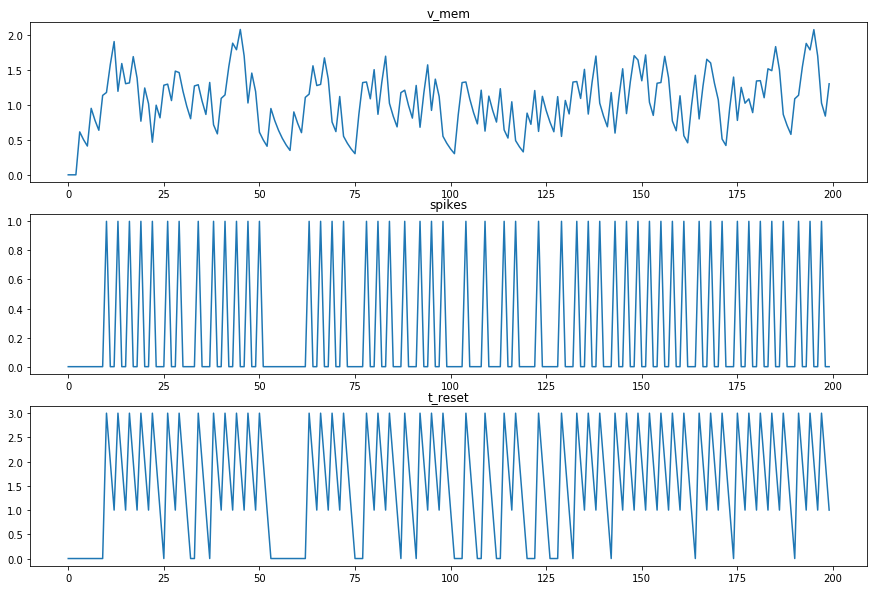

In [37]:
batch_size = 1
sequence_length = 200
num_inputs=1
num_units=1
#shape=(2, 5, 2)
input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs])
#input_spikes=np.ones([batch_size,sequence_length,num_inputs])

tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
LSNN_cell = LSNNCell(num_units=num_units,state_is_tuple=True,output_is_tuple=True,tau_s=10.0)
outputs, state = tf.nn.dynamic_rnn(cell=LSNN_cell, dtype=tf.float32, inputs=tf_input_values)

cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])

    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 
plt.figure(figsize=[15,10])
ax=plt.subplot(3,1,1)
ax.plot(output_run.v_mem.flatten())
ax.set_title('v_mem')
ax=plt.subplot(3,1,2)
ax.plot(output_run.spike.flatten())
ax.set_title('spikes')
ax=plt.subplot(3,1,3)
ax.plot(output_run.t_reset.flatten())
ax.set_title('t_reset')

rnn/lsnn_cell/W_rec:0 [[-6.07013702e-04 -3.56712669e-01  2.18325853e-03 -5.14569521e-01
   6.71778202e-01]
 [ 4.26449776e-02  2.62997746e-01 -3.24395090e-01 -3.94296169e-01
  -2.43015349e-01]
 [-2.03969181e-01 -5.46610355e-03 -1.99460804e-01 -3.15248907e-01
  -6.38146639e-01]
 [-3.52366835e-01  2.84241199e-01 -3.36205065e-01  1.23909295e-01
  -4.35304701e-01]
 [ 4.74222302e-01  4.02679801e-01  4.13580656e-01 -1.99168324e-02
   6.07872844e-01]]
rnn/lsnn_cell/W_in:0 [[ 0.5658463  -0.7601172   0.8839791   0.5638392  -0.28834158]
 [ 0.5134411   0.51029277 -0.28073627 -0.76472276  0.8468945 ]]


Text(0.5, 1.0, 't_reset')

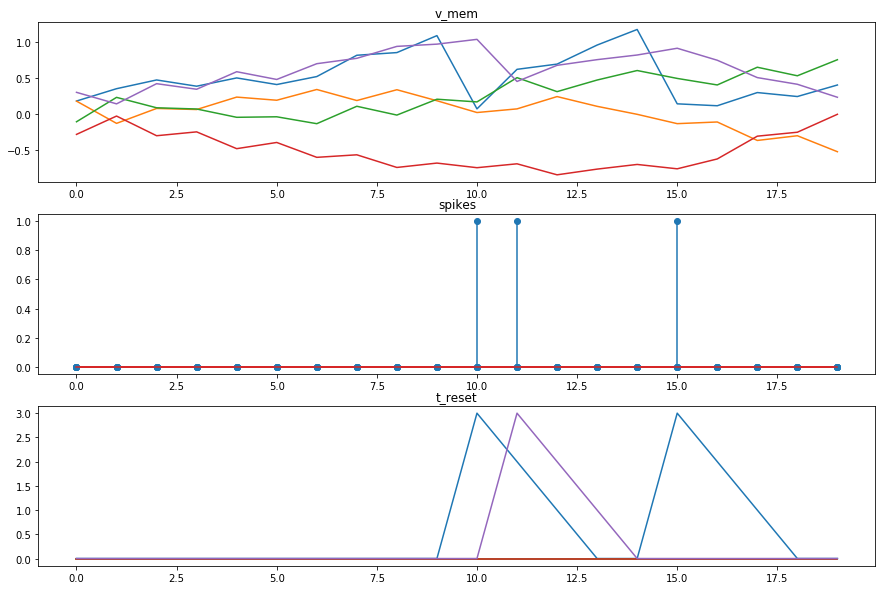

In [45]:
batch_size = 1
sequence_length = 20
num_inputs = 2
num_units=5
#shape=(2, 5, 2)
input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs])
#input_spikes=np.ones([batch_size,sequence_length,num_inputs])

tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
LSNN_cell = LSNNCell(num_units=num_units,state_is_tuple=True,output_is_tuple=True,tau_s=10.0)
outputs, state = tf.nn.dynamic_rnn(cell=LSNN_cell, dtype=tf.float32, inputs=tf_input_values)

cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run = sess.run([outputs, state])

    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 
plt.figure(figsize=[15,10])
ax=plt.subplot(3,1,1)
ax.plot(output_run.v_mem.squeeze(axis=0))
ax.set_title('v_mem')
ax=plt.subplot(3,1,2)
for i in range(5):
    ax.stem(output_run.spike.squeeze(axis=0)[:,i-1])
ax.set_title('spikes')
ax=plt.subplot(3,1,3)
ax.plot(output_run.t_reset.squeeze(axis=0))
ax.set_title('t_reset')

In [43]:
output_run.spike.squeeze(axis=0)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [46]:
range(5)

range(0, 5)